In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json

feature_names = json.loads(open('utils/lut_dict.txt').read())


In [135]:
matplotlib.font_manager.findfont('Humor Sans')


'/Users/abigailwolfensohn/Library/Fonts/Humor-Sans.ttf'

In [136]:
# HISTOGRAM
#############################################################

# create dataframes
important_features = pd.read_csv("out/important_features.csv")

# rename columns 
important_features = important_features.rename(columns={'feature': 'importance'})
important_features = important_features.rename(columns={'Unnamed: 0': 'feature'})

# save names of features where importance >=5 to a list called top_features
top_features = important_features[important_features['importance'] >= 5]
top_features = top_features['feature'].tolist()

#make list of importance of all features in top_features
top_features_importance = important_features[important_features['feature'].isin(top_features)]
top_features_importance = top_features_importance['importance'].tolist()

# reading LUT
region_names = np.array(list([feature_names[feature] for feature in important_features['feature']]))

# add label column
important_features['feature type'] = np.where(important_features['feature'].str.contains('thickness'), "thickness", 
                                       np.where(important_features['feature'].str.contains('area'), "area", None))
important_features['feature'] = region_names


In [137]:
# generate histogram
with plt.xkcd():
    ax1 = sns.catplot(data=important_features, kind="bar", x="importance", y="feature", height=15, hue="feature type", dodge=False)
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])    
    plt.savefig('out/important_features.png', dpi=300)
    plt.clf()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

In [138]:
# FEATURE WEIGHTS
#############################################################

# make a graph to visualize the feature weights data in outs folder ([fold]_feature_weights.csv)
#load df from all folds and merge into one dataframe

#create new dataframe for each fold file

dataframes = []  # List to store the dataframes

for i in range(0,10):
    filename=('out/{}_feature_weights.csv'.format(i))
     # Generate the filename
    df = pd.read_csv(filename)  # Read the CSV file into a dataframe
    dataframes.append(df)

# rename first column of each dataframe to fold #
for i in range(0,10):
    dataframes[i] = dataframes[i].rename(columns={'Unnamed: 0': 'fold #'})
    dataframes[i]['fold #'] = i

# merge all 10 dataframes within dataframes list into a single dataframe
all_weights = pd.concat(dataframes)

# replace NaNs with 0s and drop fold # column for graphing
all_weights = all_weights.fillna(0)

all_weights.head()


,fold #,lh_S_precentral-sup-part_area,rh_S_orbital_lateral_thickness,rh_G_occipital_sup_thickness,rh_G&S_frontomargin_thickness,lh_G_insular_short_thickness,rh_S_collat_transv_post_thickness,lh_G_temp_sup-Lateral_area,rh_S_intrapariet&P_trans_area,lh_S_calcarine_thickness,...,lh_G_cingul-Post-ventral_area,lh_G_subcallosal_area,lh_G_temp_sup-G_T_transv_thickness,rh_G_postcentral_area,lh_S_front_middle_thickness,rh_Pole_occipital_area,lh_S_circular_insula_ant_area,lh_S_occipital_ant_area,rh_S_precentral-sup-part_thickness,lh_Lat_Fis-ant-Vertical_area
0,0,0.153556,-0.108649,0.086896,-0.236943,0.345959,0.229389,-0.319432,0.220882,0.412049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1,0.254244,-0.037537,0.000000,0.000000,0.000000,0.307903,0.000000,0.281737,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,2,0.200072,0.000000,0.230870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,3,0.255776,0.000000,0.262871,0.000000,0.000000,0.000000,0.000000,0.233846,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,4,0.356783,0.000000,0.324836,-0.388435,0.000000,0.250339,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
# melt
all_weights = pd.melt(all_weights, id_vars=['fold #'], var_name='feature', value_name='weight')
print(all_weights)

     fold #                        feature    weight
0         0  lh_S_precentral-sup-part_area  0.153556
1         1  lh_S_precentral-sup-part_area  0.254244
2         2  lh_S_precentral-sup-part_area  0.200072
3         3  lh_S_precentral-sup-part_area  0.255776
4         4  lh_S_precentral-sup-part_area  0.356783
..      ...                            ...       ...
675       5   lh_Lat_Fis-ant-Vertical_area  0.000000
676       6   lh_Lat_Fis-ant-Vertical_area  0.000000
677       7   lh_Lat_Fis-ant-Vertical_area  0.000000
678       8   lh_Lat_Fis-ant-Vertical_area  0.000000
679       9   lh_Lat_Fis-ant-Vertical_area -0.185434

[680 rows x 3 columns]


In [140]:
# keep only top weights / replace column headers with feature_names from lut_dict.txt
top_weights = all_weights[all_weights['feature'].isin(top_features)]

region_names = np.array(list([feature_names[feature] for feature in top_weights['feature']]))
top_weights['feature'] = region_names

# abs value
top_weights['weight'] = top_weights['weight'].abs()

/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_13797/1731658937.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['feature'] = region_names
/var/folders/05/4bm5nzbd43d1zy10xs1n6j780000gn/T/ipykernel_13797/1731658937.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['weight'] = top_weights['weight'].abs()


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

<Figure size 640x480 with 0 Axes>

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

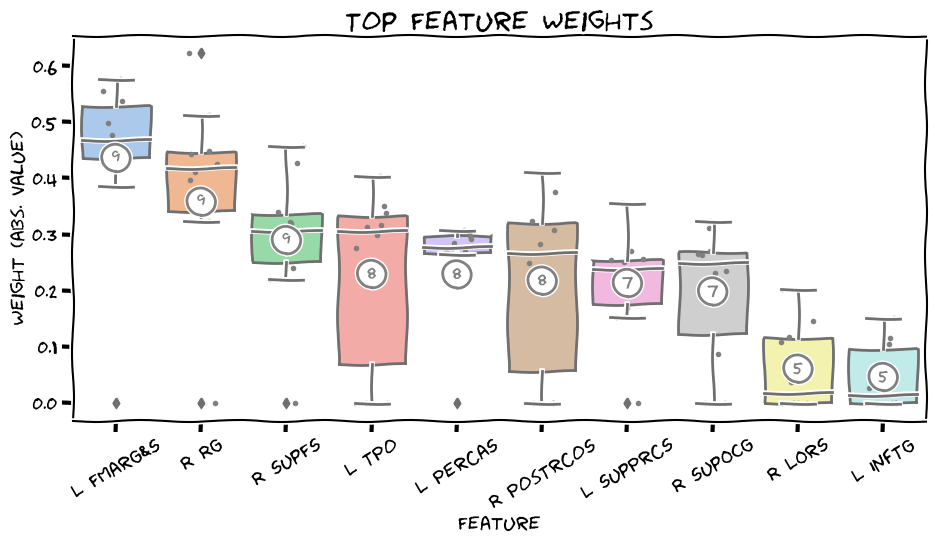

In [152]:
# boxplot of the dataframe where y=weight and x=feature

fig = plt.figure(figsize=(11, 5))
#sns.set(rc={'figure.figsize':(20, 8)})
with plt.xkcd():
    sns.boxplot(data=top_weights, x="feature", y="weight",orient="v", palette="pastel", order=top_weights.groupby('feature').mean()
                .sort_values('weight', ascending=False).index, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", 
                                                                                            "markersize":"20", "markeredgecolor":"gray", "markeredgewidth":"2"})
    # store means of boxplot in a list
    means = []
    for i in range(0, 10):
        means.append((top_weights.groupby('feature').mean().sort_values('weight', ascending=False)['weight'][i]))

    plt.xlabel('Feature')
    plt.ylabel('Weight (abs. value)')
    plt.title('Top Feature Weights', size=20)
    plt.xticks(rotation=30)
    sns.stripplot(data=top_weights, x="feature", y="weight", color="gray", zorder=1, size=4, jitter=0.2, order=top_weights.groupby('feature')
                .mean().sort_values('weight', ascending=False).index)

    # add text labels corresponding to top_features_importance at each of the means
    for i in range(0,10):
        plt.text(x=i, y=(means[i]-0.005), s=top_features_importance[i], color='gray', ha="center", fontsize=12)

    plt.savefig('out/feature_weights.png', dpi=300)
    plt.show()
    plt.clf()
